In [1]:
# Step 4 and Step 5

from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout,UpSampling2D
from tensorflow.keras.applications.xception import  Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
import warnings
warnings.filterwarnings("ignore")
import tensorflow.keras as keras
import cv2
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.layers import concatenate,Dense,Flatten,Dropout,Average
import operator
import numpy as np
from PIL import Image
from collections import defaultdict
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import concatenate,Dense,Flatten,Dropout
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
import tensorflow.keras.callbacks as kcallbacks
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler


In [2]:
#generate training and test images

TARGET_SIZE=(224,224)     # was (20,20)
INPUT_SIZE=(224,224,3)    # was (20,20,3)


BATCHSIZE=32	#could try 128 or 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        './train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 372 images belonging to 10 classes.
Found 92 images belonging to 10 classes.


In [3]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [4]:
history_this= LossHistory()


In [5]:
def xception( num_class, epochs,savepath='./xception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:121]:		#could be tuned to be 50, 100, or 131
        layer.trainable = False
    for layer in model_fine_tune.layers[121:]:
        layer.trainable = True
    
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='xception')
    opt = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#patience could be tuned by 2 and 3
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        # class_weight=class_weights,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 1.3113 - accuracy: 0.6425
Epoch 00001: val_accuracy improved from -inf to 0.29348, saving model to .\xception.h5
12/12 [==============================] - 15s 1s/step - loss: 1.3113 - accuracy: 0.6425 - val_loss: 9.7757 - val_accuracy: 0.2935
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 0.6269 - accuracy: 0.7876
Epoch 00002: val_accuracy improved from 0.29348 to 0.44565, saving model to .\xception.h5
12/12 [==============================] - 15s 1s/step - loss: 0.6269 - accuracy: 0.7876 - val_loss: 13.6447 - val_accuracy: 0.4457
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 0.3956 - accuracy: 0.8790
Epoch 00003: val_accuracy did not improve from 0.44565
12/12 [==============================] - 13s 1s/step - loss: 0.3956 - accuracy: 0.8790 - val_loss: 15.4740 - val_accuracy: 0.3152
Epoch 4/20
12/12 [==============================] - ETA: 0s - loss: 0.4214 - accuracy: 0.8978
Epo

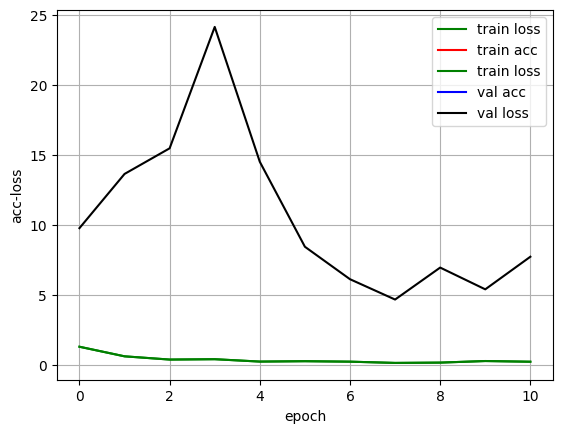

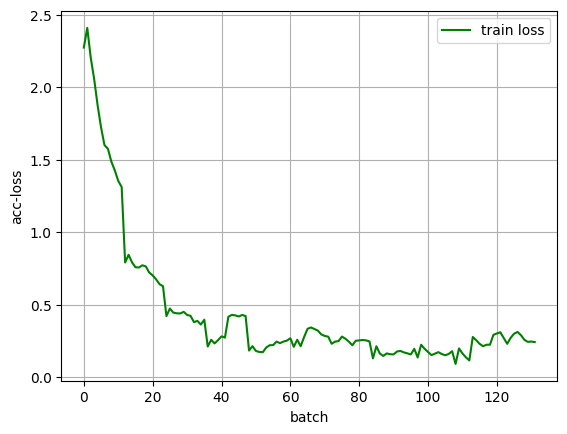

In [6]:

xception(num_class=10,epochs=20) 
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [7]:
def vgg16( num_class, epochs,savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    
    
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    for layer in model_fine_tune.layers[:15]:
        layer.trainable = False
    for layer in model_fine_tune.layers[15:]:
        layer.trainable = True
        
    
    model = GlobalAveragePooling2D()(model_fine_tune.output) 
    
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 5.4642 - accuracy: 0.1586
Epoch 00001: val_accuracy improved from -inf to 0.20652, saving model to .\VGG16.h5
12/12 [==============================] - 22s 2s/step - loss: 5.4642 - accuracy: 0.1586 - val_loss: 2.2878 - val_accuracy: 0.2065
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 2.2756 - accuracy: 0.1909
Epoch 00002: val_accuracy improved from 0.20652 to 0.27174, saving model to .\VGG16.h5
12/12 [==============================] - 22s 2s/step - loss: 2.2756 - accuracy: 0.1909 - val_loss: 2.2377 - val_accuracy: 0.2717
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 2.4156 - accuracy: 0.1586
Epoch 00003: val_accuracy did not improve from 0.27174
12/12 [==============================] - 26s 2s/step - loss: 2.4156 - accuracy: 0.1586 - val_loss: 2.2527 - val_accuracy: 0.1522
Epoch 4/20
12/12 [===========

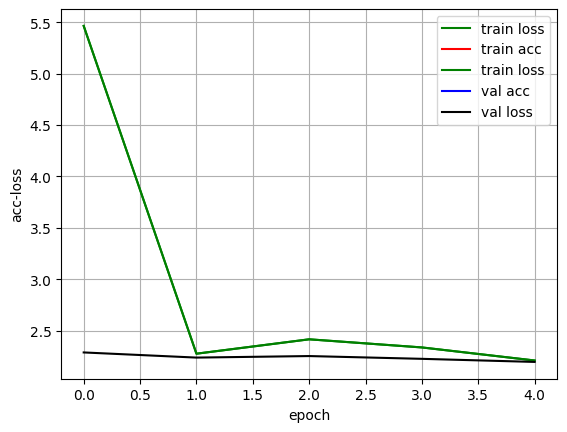

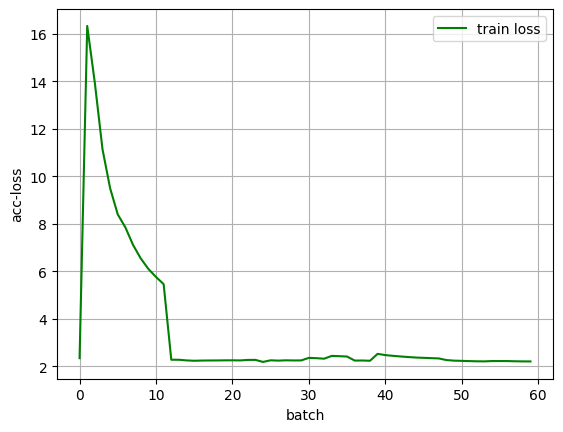

In [8]:
vgg16(num_class=10,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [9]:
def vgg19( num_class, epochs,savepath='./VGG19.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:19]:	
        layer.trainable = False
    for layer in model_fine_tune.layers[19:]:
        layer.trainable = True
        

    
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	

    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 3.4528 - accuracy: 0.1613
Epoch 00001: val_accuracy improved from -inf to 0.20652, saving model to .\VGG19.h5
12/12 [==============================] - 27s 2s/step - loss: 3.4528 - accuracy: 0.1613 - val_loss: 2.1379 - val_accuracy: 0.2065
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 2.1681 - accuracy: 0.2339
Epoch 00002: val_accuracy did not improve from 0.20652
12/12 [==============================] - 26s 2s/step - loss: 2.1681 - accuracy: 0.2339 - val_loss: 2.0438 - val_accuracy: 0.2065
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 1.9553 - accuracy: 0.2312
Epoch 00003: val_accuracy improved from 0.20652 to 0.32609, saving model to .\VGG19.h5
12/12 [==============================] - 26s 2s/step - loss: 1.9553 - accuracy: 0.2312 - val_loss: 1.8690 - val_accuracy: 0.3261
Epoch 4/20
12/12 [==============================] - ETA: 0s - loss: 1.7406 - accuracy: 0.2634
Epoch 00004

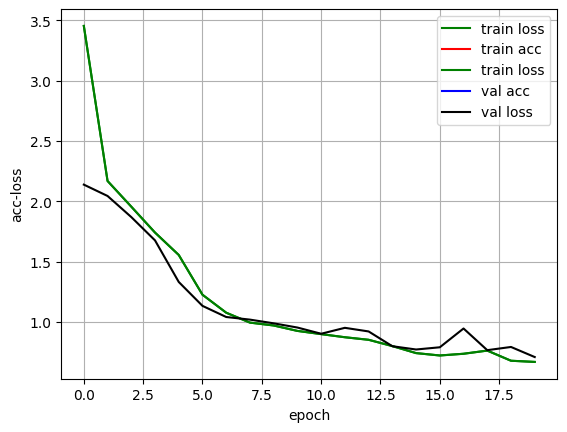

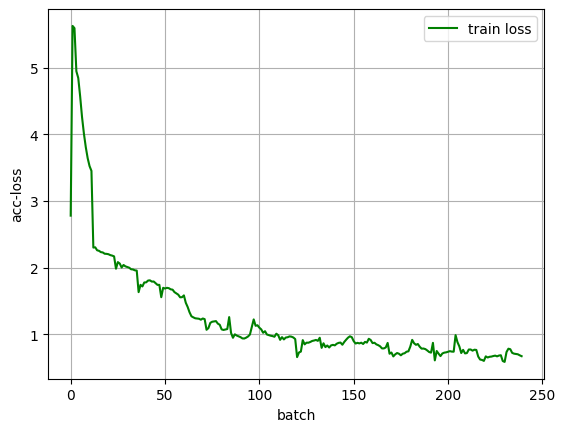

In [10]:
vgg19(num_class=10,epochs=20)	
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [13]:
def inception( num_class, epochs,savepath='./inception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:148]:	
        layer.trainable = False
    for layer in model_fine_tune.layers[148:]:	
        layer.trainable = True
        
    
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 1.2668 - accuracy: 0.5995
Epoch 00001: val_accuracy improved from -inf to 0.20652, saving model to .\inception.h5
12/12 [==============================] - 14s 1s/step - loss: 1.2668 - accuracy: 0.5995 - val_loss: 40524.4141 - val_accuracy: 0.2065
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 0.7810 - accuracy: 0.7285
Epoch 00002: val_accuracy improved from 0.20652 to 0.25000, saving model to .\inception.h5
12/12 [==============================] - 12s 1s/step - loss: 0.7810 - accuracy: 0.7285 - val_loss: 15661.8516 - val_accuracy: 0.2500
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 1.0167 - accuracy: 0.7796
Epoch 00003: val_accuracy did not improve from 0.25000
12/12 [==============================] - 12s 1s/step - loss: 1.0167 - accuracy: 0.7796 - val_loss: 10175783.0000 - val_accuracy: 0.2065
Epoch 4/20
12/12 [==============================] - ETA: 0s - loss: 0.6961 - accur

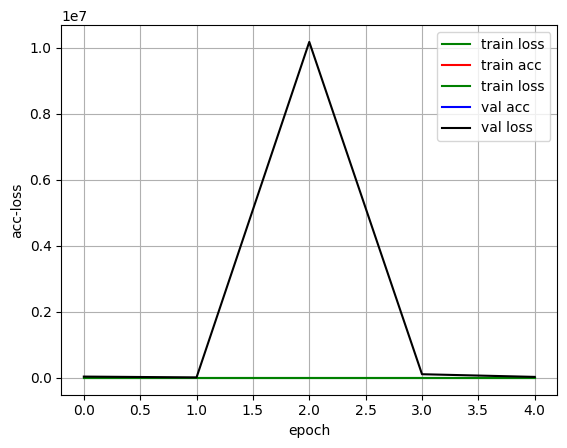

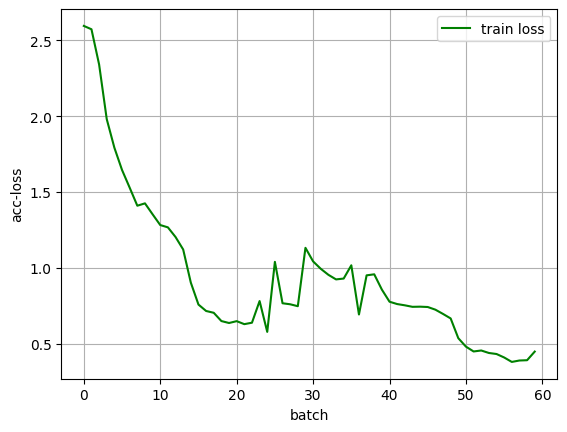

In [14]:
inception(num_class=10,epochs=20)	
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [15]:
def inceptionresnet( num_class, epochs,savepath='./inceptionresnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:522]:	
        layer.trainable = False
    for layer in model_fine_tune.layers[522:]:	
        layer.trainable = True
        
    
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 

    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 2.0214 - accuracy: 0.4570
Epoch 00001: val_accuracy improved from -inf to 0.20652, saving model to .\inceptionresnet.h5
12/12 [==============================] - 50s 4s/step - loss: 2.0214 - accuracy: 0.4570 - val_loss: 17296821059584.0000 - val_accuracy: 0.2065
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 1.0961 - accuracy: 0.6398
Epoch 00002: val_accuracy did not improve from 0.20652
12/12 [==============================] - 39s 3s/step - loss: 1.0961 - accuracy: 0.6398 - val_loss: 1002465525760.0000 - val_accuracy: 0.2065
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 1.1421 - accuracy: 0.6398
Epoch 00003: val_accuracy did not improve from 0.20652
12/12 [==============================] - 39s 3s/step - loss: 1.1421 - accuracy: 0.6398 - val_loss: 112342864.0000 - val_accuracy: 0.2065
Epoch 4/20
12/12 [==============================] - ETA: 0s - loss: 0.7281 - accuracy: 0.7177


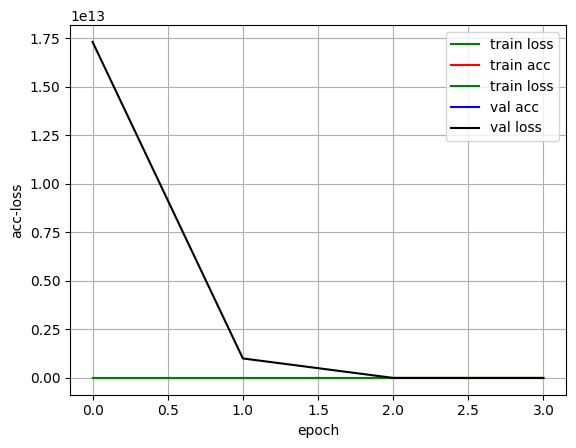

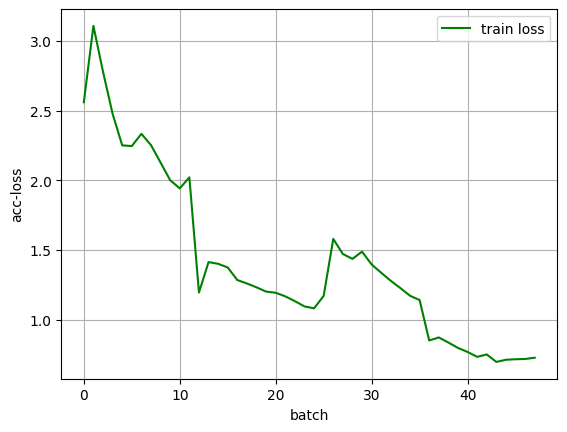

In [16]:
inceptionresnet(num_class=10,epochs=20)	# 5-class classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [24]:
#generate images from train set and validation set
TARGET_SIZE=(224,224)     
INPUT_SIZE=(224,224,3)    
BATCHSIZE=32           

test_datagen = ImageDataGenerator(rescale=1./255)

upsampled_data = False
padded_data = False

if upsampled_data:
        validation_generator = test_datagen.flow_from_directory(
                './upsampled_test/',
                target_size=TARGET_SIZE,
                batch_size=BATCHSIZE,
                class_mode='categorical')
elif padded_data:
        validation_generator = test_datagen.flow_from_directory(
                './padded_test/',
                target_size=TARGET_SIZE,
                batch_size=BATCHSIZE,
                class_mode='categorical')
        
else:
    validation_generator = test_datagen.flow_from_directory(
                './test_224/',
                target_size=TARGET_SIZE,
                batch_size=BATCHSIZE,
                class_mode='categorical')

Found 92 images belonging to 10 classes.


In [25]:
#generate labels indicating class
label=validation_generator.class_indices
label={v: k for k, v in label.items()}

In [26]:
print(label)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}


In [27]:
#read images from validation folder

rootdir = './test_224/'


test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

0 ./test_224/0\1707.png


In [28]:
 #load model 1: xception
xception_model=load_model('./xception.h5')

In [29]:
 #load model 2: VGG16
vgg_model=load_model('./VGG16.h5')

In [30]:
 #load model 3: VGG19
vgg19_model=load_model('./VGG19.h5')

In [31]:
 #load model 4: inception
incep_model=load_model('./inception.h5')

In [32]:
 #load model 5: inceptionresnet
inres_model=load_model('./inceptionresnet.h5')

In [40]:
for i,layer in enumerate(xception_model.layers):
    print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [41]:
for i,layer in enumerate(vgg_model.layers):
    print(i,layer.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_1
20 dense_2
21 dropout_1
22 dense_3


In [42]:
for i,layer in enumerate(vgg19_model.layers):
    print(i,layer.name)

0 input_3
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 global_average_pooling2d_2
23 dense_4
24 dropout_2
25 dense_5


In [43]:
for i,layer in enumerate(incep_model.layers):
    print(i,layer.name)

0 input_4
1 conv2d_4
2 batch_normalization_4
3 activation
4 conv2d_5
5 batch_normalization_5
6 activation_1
7 conv2d_6
8 batch_normalization_6
9 activation_2
10 max_pooling2d
11 conv2d_7
12 batch_normalization_7
13 activation_3
14 conv2d_8
15 batch_normalization_8
16 activation_4
17 max_pooling2d_1
18 conv2d_12
19 batch_normalization_12
20 activation_8
21 conv2d_10
22 conv2d_13
23 batch_normalization_10
24 batch_normalization_13
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_9
29 conv2d_11
30 conv2d_14
31 conv2d_15
32 batch_normalization_9
33 batch_normalization_11
34 batch_normalization_14
35 batch_normalization_15
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_19
42 batch_normalization_19
43 activation_15
44 conv2d_17
45 conv2d_20
46 batch_normalization_17
47 batch_normalization_20
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_16
52 conv2d_18
53 conv2d_21
54 conv2d_22
55 batch_normalization_16
56 batch_normal

In [44]:
for i,layer in enumerate(inres_model.layers):
    print(i,layer.name)

0 input_5
1 conv2d_98
2 batch_normalization_98
3 activation_94
4 conv2d_99
5 batch_normalization_99
6 activation_95
7 conv2d_100
8 batch_normalization_100
9 activation_96
10 max_pooling2d_4
11 conv2d_101
12 batch_normalization_101
13 activation_97
14 conv2d_102
15 batch_normalization_102
16 activation_98
17 max_pooling2d_5
18 conv2d_106
19 batch_normalization_106
20 activation_102
21 conv2d_104
22 conv2d_107
23 batch_normalization_104
24 batch_normalization_107
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_103
29 conv2d_105
30 conv2d_108
31 conv2d_109
32 batch_normalization_103
33 batch_normalization_105
34 batch_normalization_108
35 batch_normalization_109
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed_5b
41 conv2d_113
42 batch_normalization_113
43 activation_109
44 conv2d_111
45 conv2d_114
46 batch_normalization_111
47 batch_normalization_114
48 activation_107
49 activation_110
50 conv2d_110
51 conv2d_112
52 conv2d_115
53 batch_

In [45]:
model1=Model(inputs=[xception_model.layers[0].get_input_at(0)],outputs=xception_model.get_layer('dense_1').output,name='xception')
model2=Model(inputs=[vgg_model.layers[0].get_input_at(0)],outputs=vgg_model.get_layer('dense_3').output,name='vgg')
model3=Model(inputs=[vgg19_model.layers[0].get_input_at(0)],outputs=vgg19_model.get_layer('dense_5').output,name='vgg19')
model4=Model(inputs=[incep_model.layers[0].get_input_at(0)],outputs=incep_model.get_layer('dense_7').output,name='incep')
model5=Model(inputs=[inres_model.layers[0].get_input_at(0)],outputs=inres_model.get_layer('dense_9').output,name='inres')

In [46]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [47]:
ensemble_history= LossHistory()

In [48]:
#generate training and test images
TARGET_SIZE=(224,224)     
INPUT_SIZE=(224,224,3)    
BATCHSIZE=32	


train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        './train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 372 images belonging to 10 classes.
Found 92 images belonging to 10 classes.


In [49]:
def lr_decay(epoch):
    lrs = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0001,0.00001,0.000001,
           0.000001,0.000001,0.000001,0.000001,0.0000001,0.0000001,0.0000001,0.0000001,0.0000001,0.0000001
          ]
    return lrs[epoch]

In [50]:
auto_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
my_lr = LearningRateScheduler(lr_decay)

In [51]:
def ensemble(num_class,epochs,savepath='./ensemble.h5'):
    img=Input(shape=(224,224,3),name='img')
    feature1=model1(img)
    feature2=model2(img)
    feature3=model3(img)
    x=concatenate([feature1,feature2,feature3])
    x=Dropout(0.5)(x)
    x=Dense(64,activation='relu')(x)
    x=Dropout(0.25)(x)
    output=Dense(num_class,activation='softmax',name='output')(x)
    model=Model(inputs=img,outputs=output)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_accuracy',patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,ensemble_history,auto_lr],
    )

def build_ensemble_model(num_class):
    img = Input(shape=(224, 224, 3), name='img')
    feature1 = model1(img)
    feature2 = model2(img)
    feature3 = model3(img)
    x = concatenate([feature1, feature2, feature3])
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    output = Dense(num_class, activation='softmax', name='output')(x)
    model = Model(inputs=img, outputs=output)
    return model

def ensemble_load(num_class,epochs,savepath='./ensemble.h5'):
    
    model=build_ensemble_model(num_class=num_class)
    
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    #train model
    
    model.load_weights('./ensemble.h5')
    
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_accuracy',patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,ensemble_history,auto_lr],
    )

In [52]:
def load_finished_ensemble_model():
    model=build_ensemble_model(num_class=10)
    model.load_weights('./ensemble.h5')
    return model

In [53]:
ensemble_model=ensemble(num_class=10,epochs=20)

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 2.2102 - accuracy: 0.2634
Epoch 00001: val_accuracy improved from -inf to 0.33696, saving model to .\ensemble.h5
12/12 [==============================] - 53s 4s/step - loss: 2.2102 - accuracy: 0.2634 - val_loss: 2.1352 - val_accuracy: 0.3370
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 2.1164 - accuracy: 0.3548
Epoch 00002: val_accuracy improved from 0.33696 to 0.41304, saving model to .\ensemble.h5
12/12 [==============================] - 52s 4s/step - loss: 2.1164 - accuracy: 0.3548 - val_loss: 2.0434 - val_accuracy: 0.4130
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 1.9995 - accuracy: 0.4220
Epoch 00003: val_accuracy improved from 0.41304 to 0.58696, saving model to .\ensemble.h5
12/12 [==============================] - 51s 4s/step - loss: 1.9995 - accuracy: 0.4220 - val_loss: 1.9528 - val_accuracy: 0.5870
Epoch 4/20
12/12 [==============================] - ETA: 0s - lo

In [54]:
ensemble_model = load_finished_ensemble_model()

In [55]:
#read images from validation folder

rootdir = './test_224/'

test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

0 ./test_224/0\1707.png


In [56]:
#test the averaging model on the validation set

predict=[]
length=len(test_images)
t1 = time.time()
for i in range((length//127)+1):
    inputimg=test_images[127*i:127*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    #print(i, np.array(test_batch).shape)
    ensemble_model_batch=ensemble_model.predict(np.array(test_batch))
    predict_batch=list(np.argmax(ensemble_model_batch,axis=1))
    predict_batch=[label[con] for con in predict_batch]
    predict.append(predict_batch)

predict=sum(predict,[])

t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

The testing time is :10.105884 seconds


In [57]:

acc=accuracy_score(test_laels,predict)
print('Concatenation accuracy:%s'%acc)

Concatenation accuracy:0.7065217391304348


In [58]:
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('ensemble accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)

print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4', '5', '6', '7', '8', '9']
print(classification_report(test_laels, predict, target_names=target_names))

ensemble accuracy: 0.7065217391304348
precision: 0.6511583223539745
recall: 0.7065217391304348
f1: 0.6412411113100404
[[ 3  0  0  0  0  0  0  1  0  0]
 [ 1  2  0  0  0  1  0  1  0  0]
 [ 0  0  4  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  1  0  6  0  0]
 [ 0  0  0  0  0  2  0  5  0  0]
 [ 0  0  0  0  0 18  0  1  0  0]
 [ 0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0  0 19  0  0]
 [ 0  3  2  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  2  0  5]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.40      0.40      0.40         5
           2       0.67      0.80      0.73         5
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         7
           5       0.82      0.95      0.88        19
           6       1.00      1.00      1.00        13
           7       0.53      1.00      0.69        19
           8       1.00      0.17      0.29         6
          

In [59]:
# Define the dictionary for mapping encoded labels to their names
# 0: Benign
# 1: DDoS
# 2: DoS Hulk
# 3: FTP-Patator
# 4: SSH-Patator
label_map = {0: 'analysis', 1: 'backdoor', 2: 'dos', 3: 'exploits', 4: 'fuzzers', 5: 'generic', 6: 'normal', 7:'reconnaissance', 8:'shellcode', 9:'worms'}

In [60]:
y_true_list = [int(i) for i in test_laels]
y_pred_list = [int(i) for i in predict]

In [61]:
# Convert y_true and y_pred to lists
# y_true_list = list(test_laels)
# y_pred_list = list(predict)

# Map the label values to their corresponding names using list comprehension
y_true_mapped = [label_map[y] for y in y_true_list]
y_pred_mapped = [label_map[y] for y in y_pred_list]

# Generate the classification report
print(classification_report(y_true_mapped, y_pred_mapped, zero_division=1))
print('\n')
print('                    Confusion Matrix')

                precision    recall  f1-score   support

      analysis       0.75      0.75      0.75         4
      backdoor       0.40      0.40      0.40         5
           dos       0.67      0.80      0.73         5
      exploits       1.00      0.00      0.00         7
       fuzzers       1.00      0.00      0.00         7
       generic       0.82      0.95      0.88        19
        normal       1.00      1.00      1.00        13
reconnaissance       0.53      1.00      0.69        19
     shellcode       1.00      0.17      0.29         6
         worms       1.00      0.71      0.83         7

      accuracy                           0.71        92
     macro avg       0.82      0.58      0.56        92
  weighted avg       0.80      0.71      0.64        92



                    Confusion Matrix


In [62]:
report = classification_report(y_true_mapped, y_pred_mapped, zero_division=1, output_dict=True)

cm = confusion_matrix(y_true_mapped, y_pred_mapped)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)


for label, metrics in report.items():
    if isinstance(metrics, dict):  # skip accuracy, macro avg, etc.
        print(f"\nClass: {label}")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.3f}")



for class_label, acc in zip(report.keys(), per_class_accuracy):
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"Class {class_label} Accuracy: {acc * 100:.3f}%")


Class: analysis
  precision: 0.750
  recall: 0.750
  f1-score: 0.750
  support: 4.000

Class: backdoor
  precision: 0.400
  recall: 0.400
  f1-score: 0.400
  support: 5.000

Class: dos
  precision: 0.667
  recall: 0.800
  f1-score: 0.727
  support: 5.000

Class: exploits
  precision: 1.000
  recall: 0.000
  f1-score: 0.000
  support: 7.000

Class: fuzzers
  precision: 1.000
  recall: 0.000
  f1-score: 0.000
  support: 7.000

Class: generic
  precision: 0.818
  recall: 0.947
  f1-score: 0.878
  support: 19.000

Class: normal
  precision: 1.000
  recall: 1.000
  f1-score: 1.000
  support: 13.000

Class: reconnaissance
  precision: 0.528
  recall: 1.000
  f1-score: 0.691
  support: 19.000

Class: shellcode
  precision: 1.000
  recall: 0.167
  f1-score: 0.286
  support: 6.000

Class: worms
  precision: 1.000
  recall: 0.714
  f1-score: 0.833
  support: 7.000

Class: macro avg
  precision: 0.816
  recall: 0.578
  f1-score: 0.557
  support: 92.000

Class: weighted avg
  precision: 0.803
  r